In [1]:
import pandas as pd
import scipy
import itertools
import numpy as np
from time import perf_counter
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier # new
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
#from sklearn.model_selection import cross_val_score #new

#seed random number generator
from random import seed
from random import sample
seed(1)

In [2]:
#Read feature data to data frame
df_t = pd.read_csv("../../feature_files/train_features_yfilt_40s_hSNR_v4_with_thunder_without_bigsf.csv",dtype={'event_class':np.float64})
df_test = pd.read_csv('../../feature_files/test_features_yfilt_40s_hSNR_v4_with_thunder.csv')
def combine_classes_catalog_2(cat):
    cat.loc[cat['event_class'] == 2, 'event_class'] = 0 # Earthqauke Illgraben to Noise
    return cat
df_t = combine_classes_catalog_2(df_t)
df_test = combine_classes_catalog_2(df_test)


#event_names = np.array(['Noise', 'SlopeFailure'])
#tar = np.array(df_t['event_class'])
#df_t['event'] = pd.Categorical.from_codes(tar.astype(int), event_names)

features = df_t.columns[4:] #skip the first columns that do not contain features

y = np.asarray(df_t['event_class'])
X = np.asarray(df_t[features])

X_test = np.asarray(df_test[features])
y_test = np.asarray(df_test['event_class'])

In [3]:
## Declare data preprocessing steps
#pipe_rf = Pipeline([('scl', StandardScaler()),('clf', RandomForestClassifier(random_state=42))])
#
##best params from the previous models
#grid_params_rf = [{'clf__criterion': ['gini'], 'clf__min_samples_leaf': [3],
#                   'clf__max_depth': [30],'clf__min_samples_split': [2],
#                   'clf__bootstrap': [True],'clf__n_estimators':[1000],'clf__class_weight': ['balanced_subsample']}]
#
#gs_rf = GridSearchCV(estimator=pipe_rf, param_grid=grid_params_rf, scoring='accuracy', cv=2, n_jobs=4,verbose = 2)

gs_rf = BalancedRandomForestClassifier(n_estimators=1200,criterion='gini',sampling_strategy='majority', max_features='sqrt', \
                                             n_jobs=-1, min_samples_leaf = 1, max_depth=10, min_samples_split=20, \
                                             oob_score=False, bootstrap=True, class_weight=None,random_state=10)

In [5]:
#find indexes of time windows for different classes
ind_noise = np.where(df_t['event_class'] == 0)[0]
n_ev_noise = np.unique(df_t['event_idx'][ind_noise]) # nimmt jeden event_idex vom noise 1 mal
n_samples_noise = len(ind_noise)

ind_ev = np.where(df_t['event_class'] == 1)[0]
n_ev_ev = np.unique(df_t['event_idx'][ind_ev]) # nimmt jeden event_idex von events 1 mal
n_samples_ev = len(ind_ev)



#min and max number of events used for the sensitivity test and 
nevent_max = 5
nevent_min = 1
# prepare a sequence of all events
sequence = range(27)

#number of cross-folds validations and initialize index "cvi" for counting
cvi = 0
n_cv=5

#initialize arrays and list to store resutls
best_acc = np.zeros((nevent_max,n_cv))
best_bal_acc = np.zeros((nevent_max,n_cv))
best_score = np.zeros((nevent_max,n_cv))
best_params = {}

index_train_all = []
index_test_all = []

test_set = []

#ind_test1 = []
#ind_test2 = []

#initlalize variables n_sam_noise and n_sam_ev to count the number of events 
n_sam_noise = 0
n_sam_ev = 0

#define a subset of debris-flow events used for validation
#subset=[8,15]

In [5]:
##get the indexes of the time windows of debris-flow events used for validation
#for ni in subset:
#
##    ind_individual_noise = np.where(n_ev_noise1[ni] == df_t['event_idx'])[0]
#    ind_individual_ev = np.where(n_ev_ev[ni] == df_t['event_idx'])[0]
#
##    n_sam_noise += len(ind_individual_noise)
#    n_sam_ev += len(ind_individual_ev)
#
##    ind_test1.append(ind_individual_noise)
#    ind_test2.append(ind_individual_ev)

In [ ]:
##define the ration of noise events used for validation
#pr_test = 0.3
#n_ev_noise_test = np.round(len(n_ev_noise) * pr_test)
#
#n_test = []
#ind_events = np.arange(len(n_ev_noise))
#
##get the indexes of the time windows of noise events used for training and validation (testing)
#for ni in range(int(n_ev_noise_test)):
#    n_evi = int(np.floor(np.random.rand(1) * len(ind_events)))
#
#    n_ev = ind_events[n_evi]
#    n_test.append(n_ev)
#    ind_events = np.delete(ind_events, n_evi)
#    
#    
##index of training invents for the noise class
#index_train_n = ind_events.reshape((1,len(ind_events)))
#
#ind_test3 = []
#for ni in n_test:
#    ind_individual_noise = np.where(n_ev_noise[int(ni)] == df_t['event_idx'])[0]
#    ind_test3.append(ind_individual_noise)
#
##test_set.append(ind_test1)
#test_set.append(ind_test2)
#test_set.append(ind_test3)
#
#merged = list(itertools.chain(*list(itertools.chain(*test_set))))
#merged_s = np.sort(merged)
#
#index_test = merged_s
#
#testing set
#X_test = X[index_test]
#y_test = y[index_test]

In [6]:
##index of training events for the noise class
#index_train_n = ind_events.reshape((1,len(ind_events)))

array([[11.11897928, 16.46528884,  2.23705502, ...,  4.85533497,
         4.83208456,  9.68741953],
       [29.22571357, 52.72795231,  0.        , ...,  5.35484371,
         4.28482498,  9.63966869],
       [12.87967858, 63.61266667,  2.27146361, ...,  4.34382602,
         4.54332951,  8.88715553],
       ...,
       [25.0216253 , 79.86977779,  0.77585442, ...,  3.75606573,
         5.91085344,  9.66691917],
       [ 4.44064805,  4.72823333,  1.97472119, ...,  5.43009503,
         3.91006843,  9.34016345],
       [ 9.50127901, 29.60116547,  4.89248895, ...,  4.94583655,
         4.01357024,  8.95940679]])

In [6]:
#training set 
for ne in range(nevent_min, nevent_max):


    for n_ci in range(n_cv):
        
        subset = sample(range(0,len(n_ev_ev)), ne) # sequence liste mit indeces von events

        test_set = []
        index_train =[]

        print(subset)

        ind_test1 = []
        ind_test2 = []

        n_sam_noise = 0
        n_sam_ev = 0

        for ni in subset:

            ind_individual_noise = np.where(n_ev_noise[ni] == df_t['event_idx'])[0]
            ind_individual_ev = np.where(n_ev_ev[ni] == df_t['event_idx'])[0]

            n_sam_noise += len(ind_individual_noise)
            n_sam_ev += len(ind_individual_ev)

            ind_test1.append(ind_individual_noise)
            ind_test2.append(ind_individual_ev)

        n_ev_noise_test = np.round(len(n_ev_noise) * 2/3)#pr_test)

        n_test = []

        test_set.append(ind_test1)
        test_set.append(ind_test2)
        test_set.append(index_train_n)

        merged = list(itertools.chain(*list(itertools.chain(*test_set))))
        merged_s = np.sort(merged)

        index_train = merged_s


        X_train = X[index_train]
        y_train = y[index_train]


        # Fit the grid search objects
        print('Performing model optimizations...')

        print('\nEstimator: Random Forest')
        t1_start = perf_counter()
        # Fit grid search
        gs_rf.fit(X_train, y_train)

        t1_stop = perf_counter()

        print("Elapsed time during the whole program in seconds:", t1_stop - t1_start)

        # Predict on test data with best params
        y_pred = gs_rf.predict(X_test)
        # Test data accuracy of model with best params
        print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))

        print('Test set balanced accuracy: %.3f' % balanced_accuracy_score(y_test,y_pred))

        #store all scores
        best_acc[ne,n_ci]=accuracy_score(y_test, y_pred)
        best_bal_acc[ne,n_ci]=balanced_accuracy_score(y_test,y_pred)
        #best_score[ne,n_ci]=gs_rf.best_score_
        best_params[cvi] = subset
        index_train_all.append(index_train)
        index_test_all.append(index_test)

        cvi += 1


#uncomment to save the results into pickels files        
#pickle.dump([best_acc, best_score, best_params,best_bal_acc], open("sensitivity_test_cv_noise_1_3_final.p", "wb"))
#pickle.dump([index_train_all, index_test_all], open("sensitivity_test_cv_train_test_noise_1_3_final.p", "wb"))

[4]


NameError: name 'index_train_n' is not defined

In [62]:
np.where(n_ev_ev[ni] == df_t['event_idx'])[0] # bei gosia fortlaufende zahlen len 228

array([94, 95, 96])

In [33]:
np.where(df_t['event_class'] == 0) # index von noise -> ind_noise

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
        211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
        224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
        237, 238, 239, 240, 241, 242, 243, 244, 245

In [49]:
df_t['event_idx'][ind_noise] # nur die indeces vom noise und dann neuer index fortlaufend

30    15
31    15
32    16
33    16
34    16
63    33
64    33
65    35
66    35
67    35
68    36
69    36
70    36
71    36
72    38
73    38
74    38
75    38
76    38
77    38
78    38
79    39
80    39
81    39
82    39
83    40
84    40
85    40
86    40
87    41
88    41
89    41
90    42
91    42
92    44
Name: event_idx, dtype: int64

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


5
621


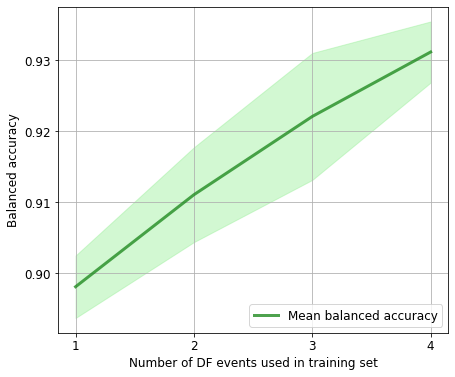

In [10]:
#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.dates as md
rc('text', usetex=False)
plt.close()
plt.rc('font',family='Helvetica')


n_events_train=np.arange(0,len(df_t)+1)
mean_ba = np.mean(best_bal_acc[1::,:],axis=1)

print(len(best_acc))
print(len(n_events_train))

std_ba = np.std(best_bal_acc[1::,:], axis=1)
tprs_upper = np.minimum(mean_ba + std_ba, 1)
tprs_lower = np.maximum(mean_ba - std_ba, 0)

plt.close()

fig, ax = plt.subplots(figsize=(7,6))
plt.rc('font',family='Helvetica')

ax.fill_between(n_events_train[nevent_min:nevent_max], tprs_lower, tprs_upper, color='lightgreen', alpha=.4)
ax.plot(n_events_train[nevent_min:nevent_max], mean_ba,color='forestgreen',
        label='Mean balanced accuracy',
        lw=3, alpha=.8)

#ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', alpha=.8)

#ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#       title="Receiver operating characteristic example")
#ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xticks(n_events_train[nevent_min:nevent_max])
ax.legend(loc="lower right",fontsize=12)
plt.xlabel('Number of DF events used in training set', fontsize=12)
plt.ylabel('Balanced accuracy', fontsize=12)
plt.grid()
#plt.savefig(f'../../plot/sensitivity/4.png', bbox_inches='tight', dpi=300)